# Carga de Datos

In [1]:

from pathlib import Path
import json
import pandas as pd
from typing import List, Dict, Any


DATA_PATH = Path("data/traficogt.txt")

def sniff_encoding(path: Path) -> str:

    with open(path, "rb") as fb:
        head = fb.read(4)
    if head.startswith(b"\xff\xfe"):
        return "utf-16-le"
    if head.startswith(b"\xfe\xff"):
        return "utf-16-be"
    if head.startswith(b"\xef\xbb\xbf"):
        return "utf-8-sig"
    if b"\x00" in head:
        return "utf-16-le"
    return "utf-8"

def iter_lines_text(path: Path):
    
    enc = sniff_encoding(path)
    with open(path, "r", encoding=enc, errors="replace") as f:
        for line in f:
            yield line

def load_jsonl_smart(filepath: Path) -> pd.DataFrame:
  
    if not filepath.exists():
        raise FileNotFoundError(f"No se encontro el archivo: {filepath.resolve()}")

    records: List[Dict[str, Any]] = []
    for raw in iter_lines_text(filepath):
        line = raw.strip()
        if not line:
            continue
        if not line.startswith("{"):
            brace = line.find("{")
            if brace != -1:
                line = line[brace:]
            else:
                continue
        
        try:
            obj = json.loads(line)
            records.append(obj)
            continue
        except json.JSONDecodeError:
            pass
        
        depth = 0
        end_index = -1
        for i, ch in enumerate(line):
            if ch == "{":
                depth += 1
            elif ch == "}":
                depth -= 1
                if depth == 0:
                    end_index = i
                    break
        if end_index != -1:
            try:
                obj = json.loads(line[: end_index + 1])
                records.append(obj)
            except Exception:
                
                pass

    if not records:
        print("no se obtuvieron registros")
        return pd.DataFrame()

    # Aplana claves anidadas
    df = pd.json_normalize(records, sep="_")

 
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True)


    preferred_cols = [
        "id", "date", "lang", "rawContent", "replyCount", "retweetCount",
        "likeCount", "quoteCount", "conversationId", "user_username",
        "user_displayname", "user_location", "user_verified",
        "user_followersCount", "user_friendsCount", "sourceLabel"
    ]
    rest = [c for c in df.columns if c not in preferred_cols]
    ordered = [c for c in preferred_cols if c in df.columns] + rest
    df = df[ordered]
    return df

df = load_jsonl_smart(DATA_PATH)


print(f"Archivo: {DATA_PATH}")
print(f"Registros cargados: {len(df):,}")
print(f"Columnas: {len(df.columns)}")

if "date" in df.columns and df["date"].notna().any():
    dmin = pd.to_datetime(df["date"].min())
    dmax = pd.to_datetime(df["date"].max())
    print(f"Rango temporal (UTC): {dmin} — {dmax}")

if "lang" in df.columns and not df.empty:
    print("Top idiomas (top 5):", df["lang"].value_counts().head(5).to_dict())


print("\nAlgunas columnas:", list(df.columns[:20]))
df.head(10)


Archivo: data/traficogt.txt
Registros cargados: 5,604
Columnas: 210
Rango temporal (UTC): 2022-12-09 15:53:32+00:00 — 2024-09-12 14:22:06+00:00
Top idiomas (top 5): {'es': 5069, 'qme': 340, 'en': 51, 'qam': 40, 'pt': 32}

Algunas columnas: ['id', 'date', 'lang', 'rawContent', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount', 'conversationId', 'user_username', 'user_displayname', 'user_location', 'user_verified', 'user_followersCount', 'user_friendsCount', 'sourceLabel', 'id_str', 'url', 'bookmarkedCount', 'conversationIdStr']


,id,date,lang,rawContent,replyCount,retweetCount,likeCount,quoteCount,conversationId,user_username,...,quotedTweet_quotedTweet_inReplyToTweetIdStr,quotedTweet_quotedTweet_inReplyToUser,quotedTweet_quotedTweet_source,quotedTweet_quotedTweet_sourceUrl,quotedTweet_quotedTweet_sourceLabel,quotedTweet_quotedTweet_media_photos,quotedTweet_quotedTweet_media_videos,quotedTweet_quotedTweet_media_animated,quotedTweet_quotedTweet_card,quotedTweet_quotedTweet__type
0,1834236045598056867,2024-09-12 14:22:06+00:00,es,Es comprensible la resolución... El ruso sabe ...,0,0,1,0,1834236045598056867,traficogt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1834029142565658846,2024-09-12 00:39:56+00:00,es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,4,1834029142565658846,monymmorales,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1834039491826180424,2024-09-12 01:21:04+00:00,qme,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,0,1834039491826180424,animaldgalaccia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1833963729136091179,2024-09-11 20:20:01+00:00,qam,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,0,0,0,0,1833963727575781534,EstacionDobleA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1833665391698092330,2024-09-11 00:34:31+00:00,es,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,0,0,1,0,1833664431084949711,CubReserva,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1833664000220893559,2024-09-11 00:29:00+00:00,es,@amilcarmontejo @PMTMuniGuate @Noti7Guatemala ...,0,0,0,0,1833664000220893559,Alejandro2024gt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1833611884664156200,2024-09-10 21:01:54+00:00,es,Favor compartir \nEl vive el zona 7 Bethania ...,0,0,0,1,1833611884664156200,JulyPonce21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1833538957847761270,2024-09-10 16:12:07+00:00,es,@traficogt @_ojoconmipisto @soy_502 @AztecaNot...,0,1,2,0,1833538957847761270,CubReserva,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1833482764139516067,2024-09-10 12:28:50+00:00,es,@piero_coen @FJimenezmingob @traficogt @mingob...,0,0,0,0,1833149672602366205,AlexDeL92022343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1833369023083360262,2024-09-10 04:56:52+00:00,es,@erwin_fern84019 @piero_coen @FJimenezmingob @...,0,0,0,0,1833149672602366205,Bullgarrafuerte,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Limpieza y procesamiento de datos


Objetivo: limpiar rawContent para analisis textual.
- Minusculas
- Quitar URLs
- Quitar @ y # pero conservar la palabra
- Quitar apostrofes
- Quitar emojis y otros simbolos
- Quitar puntuacion
- Quitar stopwords en español (lista local)
- Manejo de vacíos: si queda vacío, colocamos "NA"
- **Numeros**: se conservan por defecto también se crea text_clean_nonums sin numeros para comparar.

In [3]:
import re
import pandas as pd

assert 'df' in globals(), "No existe el DataFrame 'df'. Ejecuta primero la celda de carga."
assert 'rawContent' in df.columns, "No se encontro la columna 'rawContent' en df."

# Stopwords español (lista local, editable). Incluye variantes con/ sin tilde.
STOPWORDS_ES = {
    "a","al","algo","algunas","algunos","ante","antes","aquel","aquella","aquellas","aquellos","aqui","así","aunque",
    "bajo","bien",
    "cabe","cada","casi","como","con","contra","cual","cuales","cualquier","cualquiera","cualquieras","cuan","cuando","cuanto","cuantos",
    "de","debe","deben","debido","del","desde","despues","después","donde","dos","durante",
    "e","el","ella","ellas","ellos","empleais","emplean","emplear","empleas","en","encima","entonces","entre","era","erais","eran","eras","eres","es","esa","esas","ese","eso","esos","esta","estaba","estabais","estaban","estabas","estad","estada","estadas","estado","estados","estais","estamos","estan","estando","estar","estaremos","estaria","estarian","estarias","estas","este","esto","estos","estoy","estuvo","estuvimos","estuvieron","estuviera","estuvieran","estuviese","estuviesen","estuvimos",
    "fin","fue","fueron","fui","fuimos",
    "ha","habeis","haber","habia","habiais","habian","habias","habiamos","habida","habidas","habido","habidos","habiendo","hallais","hallamos","hallan","hallar","hallo","hasta","hay","haya","hayan","hayas","he","hemos","hube","hubiera","hubieran","hubiese","hubiesen","hubiste","hubisteis","hubimos",
    "la","las","le","les","lo","los","luego",
    "mas","más","me","mi","mis","mismo","mismos","mucha","muchas","mucho","muchos",
    "muy",
    "nada","ni","ningun","ninguna","ninguno","no","nos","nosotras","nosotros","nuestra","nuestras","nuestro","nuestros",
    "o","os","otra","otras","otro","otros",
    "para","pero","poca","pocas","poco","pocos","por","porque","primero","puede","pueden","pues",
    "que","quien","quienes","quienquiera","quienesquiera","qué",
    "se","sea","seais","seamos","sean","ser","seremos","seria","serian","serias","si","sido","siempre","siendo","sin","sino","so","sobre","sois","solamente","solo","sólo","somos","son","soy","su","sus",
    "tal","tambien","también","tampoco","tan","tanta","tantas","tanto","tantos","te","teneis","tenemos","tener","tengo","ti","tiene","tienen","toda","todas","todavia","todavía","todo","todos","tu","tus",
    "un","una","uno","unos","usa","usais","usamos","usan","usar","usas","uso",
    "usted","ustedes","va","vais","valor","vamos","van","varias","varios","vaya","verdad","vosotras","vosotros","voy","y","ya"
}

# Compilar regex de utilidad
RE_URL = re.compile(r'(https?://\S+|www\.\S+)', re.IGNORECASE)
RE_MENTION_HASHTAG = re.compile(r'[@#]+([A-Za-zÁÉÍÓÚÜÑáéíóúüñ0-9_]+)')
RE_APOSTROPHE = re.compile(r"[’'`´]")
# Emojis y simbolos
RE_EMOJI = re.compile(
    r"[\U0001F300-\U0001FAFF\u2600-\u27BF]+", flags=re.UNICODE
)
# Puntuacion y simbolos no alfanumericos (conserva letras españolas y espacio)
RE_PUNCT = re.compile(r"[^\w\sáéíóúüñÁÉÍÓÚÜÑ]")
# Guiones bajos y múltiple espacio
RE_UNDERSCORE = re.compile(r"_+")
RE_SPACES = re.compile(r"\s+")

def _tokenize(text: str):
    return text.split()

def _remove_stopwords(tokens):
    return [t for t in tokens if t not in STOPWORDS_ES]

def clean_text(
    s: str,
    remove_numbers: bool = False,
) -> str:
    if not isinstance(s, str):
        return "NA"

    # 1) Minusculas
    s = s.lower()

    # 2) Quitar URLs
    s = RE_URL.sub(" ", s)

    # 3) Quitar @ y # dejando la palabra
    s = RE_MENTION_HASHTAG.sub(r"\1", s)

    # 4) Quitar apostofres
    s = RE_APOSTROPHE.sub("", s)

    # 5) Quitar emojis
    s = RE_EMOJI.sub(" ", s)

    # 6) Quitar puntuacion
    s = RE_PUNCT.sub(" ", s)

    # 7) Opcional: quitar numeros
    if remove_numbers:
        s = re.sub(r"\d+", " ", s)

    # 8) Normalizar guiones bajos y espacios
    s = RE_UNDERSCORE.sub(" ", s)
    s = RE_SPACES.sub(" ", s).strip()

    # 9) Stopwords
    tokens = _tokenize(s)
    tokens = _remove_stopwords(tokens)

    s = " ".join(tokens).strip()

    # 10) Manejo de vacio
    if s == "":
        return "NA"
    return s

tweets = df.copy()
tweets["text_raw"] = tweets["rawContent"].astype(str)


tweets["text_clean"] = tweets["text_raw"].apply(lambda x: clean_text(x, remove_numbers=False))


tweets["text_clean_nonums"] = tweets["text_raw"].apply(lambda x: clean_text(x, remove_numbers=True))


n_total = len(tweets)
n_na_clean = (tweets["text_clean"] == "NA").sum()
n_na_nonums = (tweets["text_clean_nonums"] == "NA").sum()

print(f"Tweets procesados: {n_total:,}")
print(f'"text_clean" = "NA": {n_na_clean:,} ({n_na_clean/n_total:.1%})')
print(f'"text_clean_nonums" = "NA": {n_na_nonums:,} ({n_na_nonums/n_total:.1%})')

# Muestra de 8 filas de antes y despues
preview_cols = ["date", "user_username", "rawContent", "text_clean", "text_clean_nonums"]
display_cols = [c for c in preview_cols if c in tweets.columns]
tweets[display_cols].head(8)


Tweets procesados: 5,604
"text_clean" = "NA": 3 (0.1%)
"text_clean_nonums" = "NA": 3 (0.1%)


,date,user_username,rawContent,text_clean,text_clean_nonums
0,2024-09-12 14:22:06+00:00,traficogt,Es comprensible la resolución... El ruso sabe ...,comprensible resolución ruso sabe engrasar maq...,comprensible resolución ruso sabe engrasar maq...
1,2024-09-12 00:39:56+00:00,monymmorales,La corrupción de la @CC_Guatemala\nes descarad...,corrupción cc guatemala descarada falsificació...,corrupción cc guatemala descarada falsificació...
2,2024-09-12 01:21:04+00:00,animaldgalaccia,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,pncdeguatemala mingobguate fjimenezmingob dieg...,pncdeguatemala mingobguate fjimenezmingob dieg...
3,2024-09-11 20:20:01+00:00,EstacionDobleA,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,amilcarmontejo aztecanoticiagt bancadasemilla ...,amilcarmontejo aztecanoticiagt bancadasemilla ...
4,2024-09-11 00:34:31+00:00,CubReserva,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,502 aztecanoticiagt conapgt denunciaempagua mu...,aztecanoticiagt conapgt denunciaempagua munigu...
5,2024-09-11 00:29:00+00:00,Alejandro2024gt,@amilcarmontejo @PMTMuniGuate @Noti7Guatemala ...,amilcarmontejo pmtmuniguate noti7guatemala nue...,amilcarmontejo pmtmuniguate noti guatemala nue...
6,2024-09-10 21:01:54+00:00,JulyPonce21,Favor compartir \nEl vive el zona 7 Bethania ...,favor compartir vive zona 7 bethania traficogt...,favor compartir vive zona bethania traficogt a...
7,2024-09-10 16:12:07+00:00,CubReserva,@traficogt @_ojoconmipisto @soy_502 @AztecaNot...,traficogt ojoconmipisto 502 aztecanoticiagt az...,traficogt ojoconmipisto aztecanoticiagt azteca...


- Convertimos `date` a horario local Guatemala → `date_local`.
- Derivamos: `year`, `month`, `day`, `weekday` (0=lun), `weekday_name`, `hour`.
- Marcamos epoca de lluvia (`rainy_season = True`) para meses mayo–octubre.
- Creamos un subconjunto `tweets_basic` con columnas útiles y lo guardamos:
- Preferencia: Parquet (`data/tweets_clean.parquet`) para velocidad.
- Si falta `pyarrow/fastparquet`, guardamos en CSV (`data/tweets_clean.csv`).

In [4]:


from IPython.display import display




# Convertir a horario local de Guatemala
TZ = "America/Guatemala"
if not pd.api.types.is_datetime64_any_dtype(tweets['date']):
    tweets['date'] = pd.to_datetime(tweets['date'], errors='coerce', utc=True)
tweets['date_local'] = tweets['date'].dt.tz_convert(TZ)

# Derivados temporales
tweets['year'] = tweets['date_local'].dt.year
tweets['month'] = tweets['date_local'].dt.month
tweets['day'] = tweets['date_local'].dt.day
tweets['weekday'] = tweets['date_local'].dt.dayofweek  # 0 = lunes, 6 = domingo
weekday_map = {0:'lunes',1:'martes',2:'miércoles',3:'jueves',4:'viernes',5:'sábado',6:'domingo'}
tweets['weekday_name'] = tweets['weekday'].map(weekday_map)
tweets['hour'] = tweets['date_local'].dt.hour

# Bandera de epoca de lluvia (mayo–octubre)
tweets['rainy_season'] = tweets['month'].between(5, 10, inclusive='both')

# Dataset ligero para EDA
cols_keep = [
    'id', 'date', 'date_local', 'year', 'month', 'day', 'weekday', 'weekday_name', 'hour',
    'rainy_season', 'user_username', 'lang', 'sourceLabel',
    'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
    'text_clean', 'text_clean_nonums'
]
cols_keep = [c for c in cols_keep if c in tweets.columns]
tweets_basic = tweets[cols_keep].copy()

# Guardar (Parquet preferido; si no, CSV)
outdir = Path("data")
outdir.mkdir(parents=True, exist_ok=True)
parquet_path = outdir / "tweets_clean.parquet"
csv_path = outdir / "tweets_clean.csv"

saved_path = None
try:
    tweets_basic.to_parquet(parquet_path, index=False)
    saved_path = parquet_path
except Exception as e:
    print("No se pudo guardar Parquet Guardando CSV…")
    print("Detalle:", e)
    tweets_basic.to_csv(csv_path, index=False, encoding="utf-8")
    saved_path = csv_path


print("Shape tweets_basic:", tweets_basic.shape)
print("\nDistribucion rainy_season:")
print(tweets_basic['rainy_season'].value_counts(dropna=False))

print("\nVista rapida:")
display(tweets_basic.head(10))

print("\nArchivo guardado en:", saved_path)


Shape tweets_basic: (5604, 19)

Distribucion rainy_season:
rainy_season
True     2926
False    2678
Name: count, dtype: int64

Vista rapida:


,id,date,date_local,year,month,day,weekday,weekday_name,hour,rainy_season,user_username,lang,sourceLabel,replyCount,retweetCount,likeCount,quoteCount,text_clean,text_clean_nonums
0,1834236045598056867,2024-09-12 14:22:06+00:00,2024-09-12 08:22:06-06:00,2024,9,12,3,jueves,8,True,traficogt,es,Twitter for Android,0,0,1,0,comprensible resolución ruso sabe engrasar maq...,comprensible resolución ruso sabe engrasar maq...
1,1834029142565658846,2024-09-12 00:39:56+00:00,2024-09-11 18:39:56-06:00,2024,9,11,2,miércoles,18,True,monymmorales,es,Twitter for Android,0,56,84,4,corrupción cc guatemala descarada falsificació...,corrupción cc guatemala descarada falsificació...
2,1834039491826180424,2024-09-12 01:21:04+00:00,2024-09-11 19:21:04-06:00,2024,9,11,2,miércoles,19,True,animaldgalaccia,qme,Twitter for iPhone,0,0,1,0,pncdeguatemala mingobguate fjimenezmingob dieg...,pncdeguatemala mingobguate fjimenezmingob dieg...
3,1833963729136091179,2024-09-11 20:20:01+00:00,2024-09-11 14:20:01-06:00,2024,9,11,2,miércoles,14,True,EstacionDobleA,qam,Twitter for Android,0,0,0,0,amilcarmontejo aztecanoticiagt bancadasemilla ...,amilcarmontejo aztecanoticiagt bancadasemilla ...
4,1833665391698092330,2024-09-11 00:34:31+00:00,2024-09-10 18:34:31-06:00,2024,9,10,1,martes,18,True,CubReserva,es,Twitter for Android,0,0,1,0,502 aztecanoticiagt conapgt denunciaempagua mu...,aztecanoticiagt conapgt denunciaempagua munigu...
5,1833664000220893559,2024-09-11 00:29:00+00:00,2024-09-10 18:29:00-06:00,2024,9,10,1,martes,18,True,Alejandro2024gt,es,Twitter for Android,0,0,0,0,amilcarmontejo pmtmuniguate noti7guatemala nue...,amilcarmontejo pmtmuniguate noti guatemala nue...
6,1833611884664156200,2024-09-10 21:01:54+00:00,2024-09-10 15:01:54-06:00,2024,9,10,1,martes,15,True,JulyPonce21,es,Twitter for Android,0,0,0,1,favor compartir vive zona 7 bethania traficogt...,favor compartir vive zona bethania traficogt a...
7,1833538957847761270,2024-09-10 16:12:07+00:00,2024-09-10 10:12:07-06:00,2024,9,10,1,martes,10,True,CubReserva,es,Twitter for Android,0,1,2,0,traficogt ojoconmipisto 502 aztecanoticiagt az...,traficogt ojoconmipisto aztecanoticiagt azteca...
8,1833482764139516067,2024-09-10 12:28:50+00:00,2024-09-10 06:28:50-06:00,2024,9,10,1,martes,6,True,AlexDeL92022343,es,Twitter for Android,0,0,0,0,piero coen fjimenezmingob traficogt mingobguat...,piero coen fjimenezmingob traficogt mingobguat...
9,1833369023083360262,2024-09-10 04:56:52+00:00,2024-09-09 22:56:52-06:00,2024,9,9,0,lunes,22,True,Bullgarrafuerte,es,Twitter Web App,0,0,0,0,erwin fern84019 piero coen fjimenezmingob traf...,erwin fern piero coen fjimenezmingob traficogt...



Archivo guardado en: data/tweets_clean.parquet


# Horarios con mayor trafico

Enfoque:
- Tomamos tweets_basic
- Definimos un filtro heuristico de congestión sobre text_clean.
- Contamos tweets por hora del dia y comparamos epoca de lluvia y seca
- Se genera la tabla de top horas y grafico simple.



== Top horas (general) por tweets de congestion ==


,total_tweets,congestion_tweets,congestion_share
hour,,,
14,353,284,0.805
18,369,266,0.721
17,354,260,0.734
19,333,242,0.727
13,352,241,0.685
15,317,220,0.694
12,302,215,0.712
16,282,198,0.702



== Top horas (epoca de lluvia) ==


,rainy_season,hour,total_tweets,congestion_tweets,congestion_share
42,True,18,232,164,0.707
41,True,17,169,136,0.805
44,True,20,164,134,0.817
45,True,21,162,132,0.815
37,True,13,188,122,0.649
39,True,15,178,121,0.680
43,True,19,172,120,0.698
38,True,14,153,118,0.771



== Top horas (epoca seca) ==


,rainy_season,hour,total_tweets,congestion_tweets,congestion_share
14,False,14,200,166,0.830
12,False,12,161,127,0.789
7,False,7,163,124,0.761
17,False,17,185,124,0.670
19,False,19,161,122,0.758
13,False,13,164,119,0.726
18,False,18,137,102,0.745
15,False,15,139,99,0.712


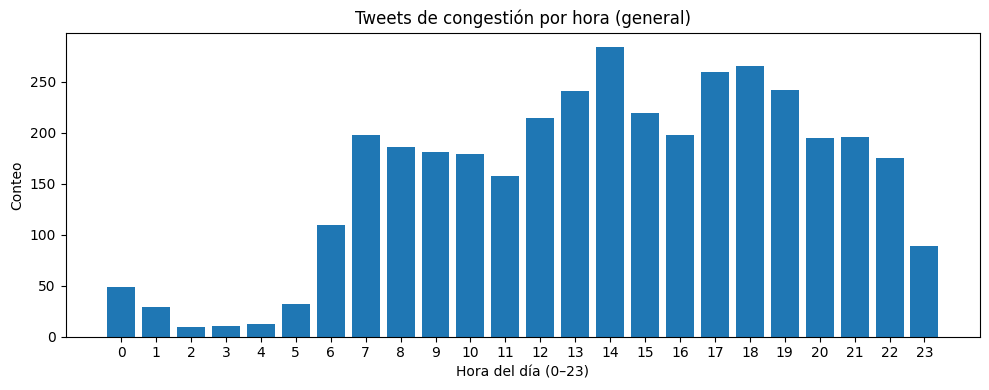

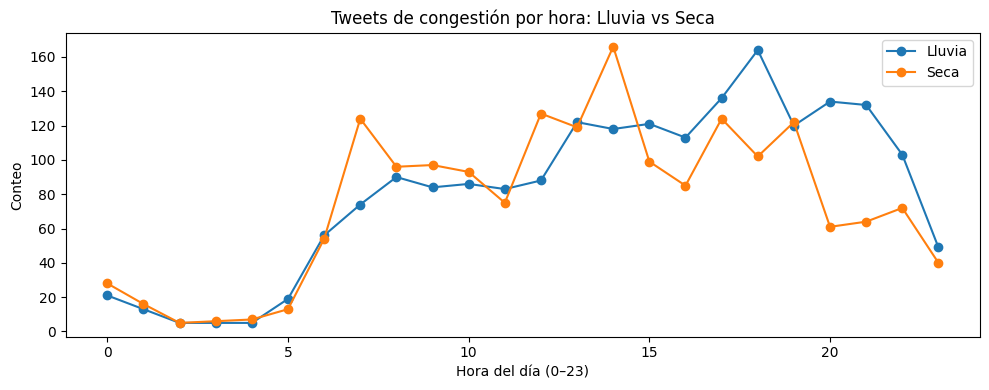

In [7]:

import matplotlib.pyplot as plt

if 'tweets_basic' not in globals():
    path = Path("data/tweets_clean.parquet")
    if path.exists():
        tweets_basic = pd.read_parquet(path)
    else:
        raise FileNotFoundError("No encuentro data/tweets_clean.parquet ni la variable tweets_basic en memoria.")


required_cols = {"date_local", "hour", "rainy_season", "text_clean", "lang"}
missing = required_cols - set(tweets_basic.columns)
assert not missing, f"Faltan columnas en tweets_basic: {missing}"

kw_pattern = re.compile(
    r"\b("
    r"trafic[oó]"
    r"|atasc[oa]s?"
    r"|congesti[óo]n|congestionad[oa]s?"
    r"|lento[s]?"
    r"|accidente[s]?"
    r"|choque[s]?"
    r"|colapsad[oa]s?"
    r"|embotellamiento[s]?|embotellad[oa]s?"
    r"|obstrucci[óo]n"
    r"|paralizad[oa]s?"
    r"|carga\s+vehicular"
    r"|vehicular\b"
    r")",
    flags=re.IGNORECASE
)

dfh = tweets_basic.copy()


dfh = dfh[dfh["lang"].fillna("").str.startswith("es")]

dfh["is_congestion"] = dfh["text_clean"].fillna("").apply(lambda s: bool(kw_pattern.search(s)))


by_hour_all = (
    dfh.groupby("hour")
       .agg(
           total_tweets=("text_clean", "size"),
           congestion_tweets=("is_congestion", "sum")
       )
       .assign(congestion_share=lambda d: (d["congestion_tweets"] / d["total_tweets"]).round(3))
       .sort_index()
)

by_hour_rain = (
    dfh.groupby(["rainy_season", "hour"])
       .agg(
           total_tweets=("text_clean", "size"),
           congestion_tweets=("is_congestion", "sum")
       )
       .assign(congestion_share=lambda d: (d["congestion_tweets"] / d["total_tweets"]).round(3))
       .reset_index()
)


top_overall = by_hour_all.sort_values("congestion_tweets", ascending=False).head(8)
top_rainy = (by_hour_rain[by_hour_rain["rainy_season"]==True]
             .sort_values("congestion_tweets", ascending=False)
             .head(8))
top_dry = (by_hour_rain[by_hour_rain["rainy_season"]==False]
           .sort_values("congestion_tweets", ascending=False)
           .head(8))

print("== Top horas (general) por tweets de congestion ==")
display(top_overall)

print("\n== Top horas (epoca de lluvia) ==")
display(top_rainy)

print("\n== Top horas (epoca seca) ==")
display(top_dry)


plt.figure(figsize=(10,4))
plt.bar(by_hour_all.index.astype(str), by_hour_all["congestion_tweets"])
plt.title("Tweets de congestión por hora (general)")
plt.xlabel("Hora del día (0–23)")
plt.ylabel("Conteo")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


pivot_ls = (by_hour_rain
            .pivot(index="hour", columns="rainy_season", values="congestion_tweets")
            .fillna(0)
            .sort_index())

plt.figure(figsize=(10,4))

plt.plot(pivot_ls.index, pivot_ls.get(True, pd.Series(index=pivot_ls.index, dtype=float)), marker="o", label="Lluvia")
plt.plot(pivot_ls.index, pivot_ls.get(False, pd.Series(index=pivot_ls.index, dtype=float)), marker="o", label="Seca")
plt.title("Tweets de congestión por hora: Lluvia vs Seca")
plt.xlabel("Hora del día (0–23)")
plt.ylabel("Conteo")
plt.legend()
plt.tight_layout()
plt.show()


Heuristica:
- Diccionario de toponimia (Periférico, Roosevelt, etc.)
- Patrones: `zona N`, `CA-<num>`, `km <num>`.
- Filtramos solo tweets marcados como congestion de arriba.


== Top 20 lugares por tweets de congestion detectados ==


,locations,total
28,Zona 1,28
27,Villa Nueva,19
41,Zona 9,11
29,Zona 10,11
25,Mixco,11
35,Zona 2,9
38,Zona 6,9
34,Zona 16,8
17,KM-14,7
8,Calzada Roosevelt,6



== Top 10 (epoca de lluvia) ==


,Seca,Lluvia
locations,,
Zona 1,17.0,11.0
Zona 10,2.0,9.0
Villa Nueva,14.0,5.0
Zona 2,4.0,5.0
Zona 16,3.0,5.0
Zona 9,7.0,4.0
Boulevard Los Próceres,0.0,4.0
Avenida Reforma,1.0,4.0
KM-14,3.0,4.0



== Top 10 (epoca seca) ==


,Seca,Lluvia
locations,,
Zona 1,17.0,11.0
Villa Nueva,14.0,5.0
Mixco,8.0,3.0
Zona 9,7.0,4.0
Zona 6,6.0,3.0
Zona 5,4.0,1.0
Zona 2,4.0,5.0
San Cristóbal,3.0,2.0
Calzada Roosevelt,3.0,3.0


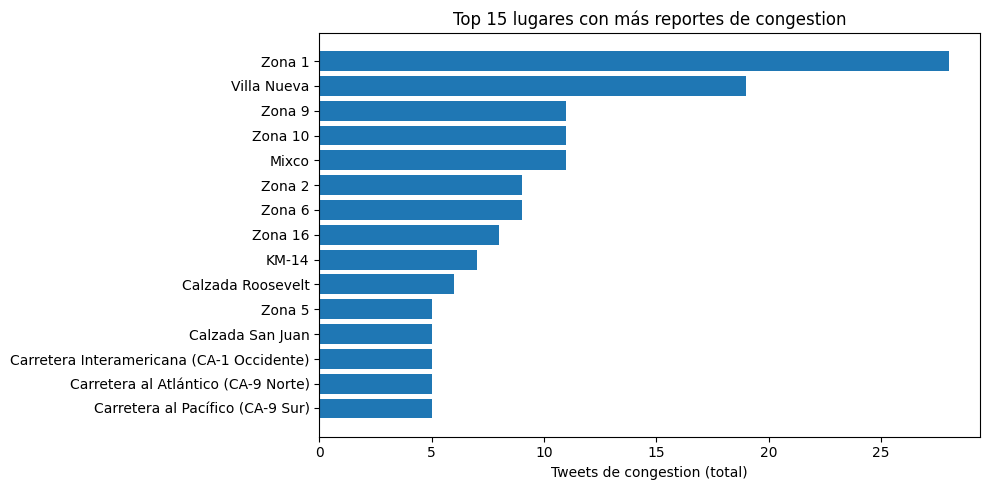

In [8]:




if 'is_congestion' not in tweets_basic.columns:
    import re
    kw_pattern = re.compile(
        r"\b("
        r"trafic[oó]"
        r"|atasc[oa]s?"
        r"|congesti[óo]n|congestionad[oa]s?"
        r"|lento[s]?"
        r"|accidente[s]?"
        r"|choque[s]?"
        r"|colapsad[oa]s?"
        r"|embotellamiento[s]?|embotellad[oa]s?"
        r"|obstrucci[óo]n"
        r"|paralizad[oa]s?"
        r"|carga\s+vehicular"
        r")",
        flags=re.IGNORECASE
    )
    dfh = tweets_basic.copy()
    dfh = dfh[dfh["lang"].fillna("").str.startswith("es")]
    tweets_basic["is_congestion"] = dfh["text_clean"].fillna("").apply(lambda s: bool(kw_pattern.search(s)))


TOPONYMS = {
    # Vias principales GUA
    r"\banillo\s+periferic[oa]\b|\bperiferic[oa]\b|\bperi\b": "Anillo Periférico",
    r"\bcalzada\s+roosevelt\b|\broosevelt\b": "Calzada Roosevelt",
    r"\bcalzada\s+aguilar\s+batres\b|\baguilar\s+batres\b|\baguilarbatres\b": "Calzada Aguilar Batres",
    r"\bcalzada\s+san\s+juan\b|\bsan\s+juan\b": "Calzada San Juan",
    r"\bavenida\s+petapa\b|\bpetapa\b": "Avenida Petapa",
    r"\bb(ou)?levar(d)?\s+liberaci[oó]n\b|\bliberaci[oó]n\b": "Bulevar Liberación",
    r"\bavenida\s+reforma\b|\breforma\b": "Avenida Reforma",
    r"\batanasio\s+tzul\b|\batanasio\b": "Calzada Atanasio Tzul",
    r"\bhincapi[eé]\b": "Hincapié",
    r"\blos\s+pr[oó]ceres\b|\bpr[oó]ceres\b": "Boulevard Los Próceres",
    r"\blas\s+am[eé]ricas\b": "Avenida Las Américas",
    # Nudos / puntos
    r"\bel\s+tr[eé]bol\b|\btr[eé]bol\b": "El Trébol",
    r"\bobelisco\b": "Obelisco",
    r"\bpuente\s+belice\b": "Puente Belice",
    r"\bpuente\s+(del\s+)?incienso\b|\bincienso\b": "Puente El Incienso",
    # Carreteras principales
    r"\bcarretera\s+a(l)?\s+el\s+salvador\b|\bcarretera\s+el\s+salvador\b": "Carretera a El Salvador (CA-1 Oriente)",
    r"\bcarretera\s+a(l)?\s+pac[íi]fico\b|\bpac[íi]fico\b": "Carretera al Pacífico (CA-9 Sur)",
    r"\bcarretera\s+a(l)?\s+atl[aá]ntico\b|\batl[aá]ntico\b": "Carretera al Atlántico (CA-9 Norte)",
    r"\binteramericana\b|\bcarretera\s+interamericana\b": "Carretera Interamericana (CA-1 Occidente)",
    # areas / municipios cercanos
    r"\bsan\s+crist[oó]bal\b|\bciudad\s+san\s+crist[oó]bal\b": "San Cristóbal",
    r"\bel\s+naranjo\b": "El Naranjo",
    r"\bmixco\b": "Mixco",
    r"\bvilla\s+nueva\b|\bvillenueva\b": "Villa Nueva",
    r"\bboca\s+del\s+monte\b": "Boca del Monte",
}

# 3) Patrones adicionales
RE_ZONA = re.compile(r"\bz(?:ona)?\s*(\d{1,2})\b")   # zona 1..25
RE_CA   = re.compile(r"\bca[-\s]?(\d{1,2})\b")       # CA-1, CA-9, etc.
RE_KM   = re.compile(r"\bkm\s*(\d{1,3})\b", re.IGNORECASE)
 #Devuelve una lista  de lugares canon detectados en los tweets
def extract_locations(text: str):
   
    locs = []

    if not isinstance(text, str) or not text:
        return locs

    s = text.lower()

    # Toponimia por diccionario
    for pat, canon in TOPONYMS.items():
        if re.search(pat, s):
            locs.append(canon)

    # Zonas (zona 1..25)
    for m in RE_ZONA.finditer(s):
        num = int(m.group(1))
        if 0 < num <= 25:
            locs.append(f"Zona {num}")

    # Carreteras tipo CA-*
    for m in RE_CA.finditer(s):
        locs.append(f"CA-{m.group(1)}")

   
    for m in RE_KM.finditer(s):
        locs.append(f"KM-{m.group(1)}")

    # unicos y orden estable
    seen = set()
    uniq = []
    for x in locs:
        if x not in seen:
            uniq.append(x)
            seen.add(x)
    return uniq

# Filtrar congestion
base = tweets_basic[
    (tweets_basic["is_congestion"] == True) &
    (tweets_basic["lang"].fillna("").str.startswith("es"))
].copy()

# Extraer lugares
base["locations"] = base["text_clean"].fillna("").apply(extract_locations)

# Explode -> contar por lugar y epoca
long_locs = base.explode("locations", ignore_index=True)
long_locs = long_locs[long_locs["locations"].notna() & (long_locs["locations"] != "")]
by_loc_season = (long_locs
                 .groupby(["locations", "rainy_season"])
                 .size()
                 .reset_index(name="count"))
by_loc_total = (by_loc_season
                .groupby("locations")["count"]
                .sum()
                .reset_index(name="total")
                .sort_values("total", ascending=False))

# Tablas: Top 20 general y Top 10 por estacion
top20 = by_loc_total.head(20)
print("== Top 20 lugares por tweets de congestion detectados ==")
display(top20)

pivot_ls = by_loc_season.pivot(index="locations", columns="rainy_season", values="count").fillna(0)
pivot_ls.columns = ["Seca", "Lluvia"] if list(pivot_ls.columns) == [False, True] else pivot_ls.columns
top10_rain = pivot_ls.sort_values("Lluvia", ascending=False).head(10)
top10_dry  = pivot_ls.sort_values("Seca", ascending=False).head(10)

print("\n== Top 10 (epoca de lluvia) ==")
display(top10_rain)

print("\n== Top 10 (epoca seca) ==")
display(top10_dry)

# 8) Gráfico Top 15 general
top15 = by_loc_total.head(15).set_index("locations")
plt.figure(figsize=(10,5))
plt.barh(top15.index[::-1], top15["total"][::-1])
plt.xlabel("Tweets de congestion (total)")
plt.title("Top 15 lugares con más reportes de congestion")
plt.tight_layout()
plt.show()


- Uso de `long_locs` (lugares extraídos)
- Metricas por lugar x año: conteo y participacion.
- Salidas:
  1) Tabla principal ordenada por 2024 (conteo, share 2023–2024, Δconteo, Δshare, Δranking).
  2) Top subidas y caidas por conteo.
  3) Grafico de conteo para los 12 lugares top-2024.

== Lugares: 2023 vs 2024 (ordenados por 2024) ==


year,2023,2024,share_2023,share_2024,delta_count,delta_share,rank_2023,rank_2024,delta_rank
locations,,,,,,,,,
Zona 1,4,24,0.08,0.1589,20,0.0789,3.0,1.0,2
Mixco,0,11,0.00,0.0728,11,0.0728,24.0,2.0,22
Zona 9,1,10,0.02,0.0662,9,0.0462,11.0,3.0,8
Villa Nueva,9,10,0.18,0.0662,1,-0.1138,1.0,3.0,-2
Zona 10,2,9,0.04,0.0596,7,0.0196,7.0,5.0,2
Zona 2,1,8,0.02,0.0530,7,0.0330,11.0,6.0,5
Zona 16,2,6,0.04,0.0397,4,-0.0003,7.0,7.0,0
El Trébol,0,5,0.00,0.0331,5,0.0331,24.0,8.0,16
Zona 5,0,5,0.00,0.0331,5,0.0331,24.0,8.0,16



== Mayores subidas (dif conteo) ==


year,2023,2024,share_2023,share_2024,delta_count,delta_share,rank_2023,rank_2024,delta_rank
locations,,,,,,,,,
Zona 1,4,24,0.08,0.1589,20,0.0789,3.0,1.0,2
Mixco,0,11,0.00,0.0728,11,0.0728,24.0,2.0,22
Zona 9,1,10,0.02,0.0662,9,0.0462,11.0,3.0,8
Zona 10,2,9,0.04,0.0596,7,0.0196,7.0,5.0,2
Zona 2,1,8,0.02,0.0530,7,0.0330,11.0,6.0,5
El Trébol,0,5,0.00,0.0331,5,0.0331,24.0,8.0,16
Zona 5,0,5,0.00,0.0331,5,0.0331,24.0,8.0,16
Zona 16,2,6,0.04,0.0397,4,-0.0003,7.0,7.0,0
Boulevard Los Próceres,0,4,0.00,0.0265,4,0.0265,24.0,11.0,13



== Mayores caidas (dif conteo) ==


year,2023,2024,share_2023,share_2024,delta_count,delta_share,rank_2023,rank_2024,delta_rank
locations,,,,,,,,,
KM-14,5,2,0.10,0.0132,-3,-0.0868,2.0,21.0,-19
Carretera al Pacífico (CA-9 Sur),4,1,0.08,0.0066,-3,-0.0734,3.0,25.0,-22
KM-17,2,0,0.04,0.0000,-2,-0.0400,7.0,40.0,-33
Zona 14,1,0,0.02,0.0000,-1,-0.0200,11.0,40.0,-29
Anillo Periférico,1,0,0.02,0.0000,-1,-0.0200,11.0,40.0,-29
Zona 12,1,1,0.02,0.0066,0,-0.0134,11.0,25.0,-14
Calzada Atanasio Tzul,1,1,0.02,0.0066,0,-0.0134,11.0,25.0,-14
Calzada Aguilar Batres,1,1,0.02,0.0066,0,-0.0134,11.0,25.0,-14
Calzada Roosevelt,3,3,0.06,0.0199,0,-0.0401,6.0,16.0,-10


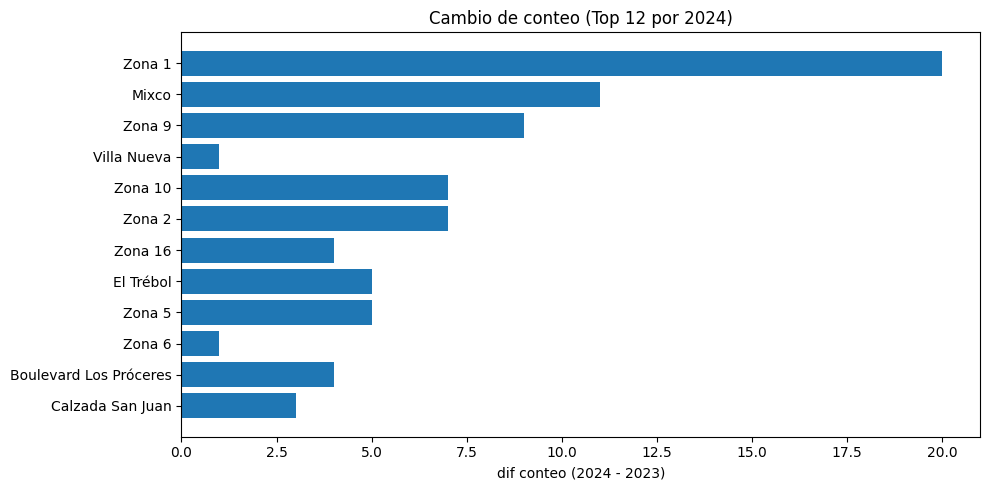

In [ ]:


if 'is_congestion' not in tweets_basic.columns:
    kw_pattern = re.compile(
        r"\b("
        r"trafic[oó]"
        r"|atasc[oa]s?"
        r"|congesti[óo]n|congestionad[oa]s?"
        r"|lento[s]?"
        r"|accidente[s]?"
        r"|choque[s]?"
        r"|colapsad[oa]s?"
        r"|embotellamiento[s]?|embotellad[oa]s?"
        r"|obstrucci[óo]n"
        r"|paralizad[oa]s?"
        r"|carga\s+vehicular"
        r")",
        flags=re.IGNORECASE
    )
    tmp = tweets_basic[tweets_basic["lang"].fillna("").str.startswith("es")].copy()
    tweets_basic["is_congestion"] = tmp["text_clean"].fillna("").apply(lambda s: bool(kw_pattern.search(s)))

if 'locations' not in tweets_basic.columns:
    TOPONYMS = {
        r"\banillo\s+periferic[oa]\b|\bperiferic[oa]\b|\bperi\b": "Anillo Periférico",
        r"\bcalzada\s+roosevelt\b|\broosevelt\b": "Calzada Roosevelt",
        r"\bcalzada\s+aguilar\s+batres\b|\baguilar\s+batres\b|\baguilarbatres\b": "Calzada Aguilar Batres",
        r"\bcalzada\s+san\s+juan\b|\bsan\s+juan\b": "Calzada San Juan",
        r"\bavenida\s+petapa\b|\bpetapa\b": "Avenida Petapa",
        r"\bb(ou)?levar(d)?\s+liberaci[oó]n\b|\bliberaci[oó]n\b": "Bulevar Liberación",
        r"\bavenida\s+reforma\b|\breforma\b": "Avenida Reforma",
        r"\batanasio\s+tzul\b|\batanasio\b": "Calzada Atanasio Tzul",
        r"\bhincapi[eé]\b": "Hincapié",
        r"\blos\s+pr[oó]ceres\b|\bpr[oó]ceres\b": "Boulevard Los Próceres",
        r"\blas\s+am[eé]ricas\b": "Avenida Las Américas",
        r"\bel\s+tr[eé]bol\b|\btr[eé]bol\b": "El Trébol",
        r"\bobelisco\b": "Obelisco",
        r"\bpuente\s+belice\b": "Puente Belice",
        r"\bpuente\s+(del\s+)?incienso\b|\bincienso\b": "Puente El Incienso",
        r"\bcarretera\s+a(l)?\s+el\s+salvador\b|\bcarretera\s+el\s+salvador\b": "Carretera a El Salvador (CA-1 Oriente)",
        r"\bcarretera\s+a(l)?\s+pac[íi]fico\b|\bpac[íi]fico\b": "Carretera al Pacífico (CA-9 Sur)",
        r"\bcarretera\s+a(l)?\s+atl[aá]ntico\b|\batl[aá]ntico\b": "Carretera al Atlántico (CA-9 Norte)",
        r"\binteramericana\b|\bcarretera\s+interamericana\b": "Carretera Interamericana (CA-1 Occidente)",
        r"\bsan\s+crist[oó]bal\b|\bciudad\s+san\s+crist[oó]bal\b": "San Cristóbal",
        r"\bel\s+naranjo\b": "El Naranjo",
        r"\bmixco\b": "Mixco",
        r"\bvilla\s+nueva\b|\bvillenueva\b": "Villa Nueva",
        r"\bboca\s+del\s+monte\b": "Boca del Monte",
    }
    RE_ZONA = re.compile(r"\bz(?:ona)?\s*(\d{1,2})\b")  
    RE_CA   = re.compile(r"\bca[-\s]?(\d{1,2})\b")       
    RE_KM   = re.compile(r"\bkm\s*(\d{1,3})\b", re.IGNORECASE)

    def extract_locations(text: str):
        locs = []
        if not isinstance(text, str) or not text:
            return locs
        s = text.lower()
        for pat, canon in TOPONYMS.items():
            if re.search(pat, s):
                locs.append(canon)
        for m in RE_ZONA.finditer(s):
            n = int(m.group(1))
            if 0 < n <= 25:
                locs.append(f"Zona {n}")
        for m in RE_CA.finditer(s):
            locs.append(f"CA-{m.group(1)}")
        for m in RE_KM.finditer(s):
            locs.append(f"KM-{m.group(1)}")
    
        seen, uniq = set(), []
        for x in locs:
            if x not in seen:
                uniq.append(x); seen.add(x)
        return uniq

    tweets_basic["locations"] = tweets_basic["text_clean"].fillna("").apply(extract_locations)


base = tweets_basic[
    tweets_basic["lang"].fillna("").str.startswith("es")
    & (tweets_basic["is_congestion"] == True)
].copy()

# Explode lugares
long_locs = base.explode("locations", ignore_index=True)
long_locs = long_locs[long_locs["locations"].notna() & (long_locs["locations"] != "")].copy()

# Agregacion por lugar x año
loc_year = (long_locs
            .groupby(["locations", "year"])
            .size()
            .reset_index(name="count"))

# Nos quedamos con 2023 y 2024
loc_year = loc_year[loc_year["year"].isin([2023, 2024])].copy()

# Totales por año para share
tot_year = loc_year.groupby("year")["count"].sum().to_dict()

# Pivot en columnas 2023/2024
wide = loc_year.pivot(index="locations", columns="year", values="count").fillna(0).astype(int)
for y in [2023, 2024]:
    wide[f"share_{y}"] = (wide.get(y, 0) / max(tot_year.get(y, 1), 1)).round(4)

# Cambios
wide["delta_count"] = wide.get(2024, 0) - wide.get(2023, 0)
wide["delta_share"] = (wide["share_2024"] - wide["share_2023"]).round(4)

# Rankings por año
wide["rank_2023"] = wide.get(2023, 0).rank(ascending=False, method="min")
wide["rank_2024"] = wide.get(2024, 0).rank(ascending=False, method="min")
wide["delta_rank"] = (wide["rank_2023"] - wide["rank_2024"]).astype("Int64")

# Orden principal: top por 2024
summary = wide.sort_values([2024, "delta_count"], ascending=[False, False]).copy()

# Mostrar tabla principal (top 20)
cols_show = [2023, 2024, "share_2023", "share_2024", "delta_count", "delta_share", "rank_2023", "rank_2024", "delta_rank"]
print("== Lugares: 2023 vs 2024 (ordenados por 2024) ==")
display(summary[cols_show].head(20))

# Top subidas/caidas por conteo
rising = summary.sort_values("delta_count", ascending=False).head(10)
falling = summary.sort_values("delta_count", ascending=True).head(10)

print("\n== Mayores subidas (dif conteo) ==")
display(rising[cols_show])

print("\n== Mayores caidas (dif conteo) ==")
display(falling[cols_show])

# Grafico: Δconteo para los 12 lugares top-2024
top12_2024 = summary.head(12)
plt.figure(figsize=(10,5))
plt.barh(top12_2024.index[::-1], top12_2024["delta_count"][::-1])
plt.xlabel("dif conteo (2024 - 2023)")
plt.title("Cambio de conteo (Top 12 por 2024)")
plt.tight_layout()
plt.show()


En 2024 el foco de reportes de congestion se desplaza claramente hacia Zona 1, Mixco y Zona 9. Zona 1 pasa de 4 a 24 menciones, Mixco pasa de 0 a 11 y Zona 9 sube 1 a 10. Villa Nueva, que en 2023 fue la #1, se mantiene en el top pero pierde peso relativo. Tambien crecen Zona 10 y Zona 2. En contraste, corredores “tradicionales” muestran caídas: CA-9 Sur y KM-14 bajan y la calzada Roosevelt se estanca en conteo pero reduce participacion. En conjunto, la señal sugiere un desplazamiento del atascamiento reportado hacia areas céntricas (Z1, Z9, Z10) y el area del gran Mixco la tierra del chicharron, mientras algunos ejes interurbanos pierden protagonismo en los reportes.


# Efecto de lluvia por lugar

- Construimos share por lugar × (año, lluvia/seca).
- Definimos prima de lluvia= share_lluvia − share_seca (por año).
- Se generaran datos de:
  1) **Top 2024** por prima de lluvia (lugares que “empeoran” con lluvia).
  2) **Top 2024** por prima negativa (lugares que no dependen de la lluvia o mejoran en seca).
  3) **Persistencia**: lugares con prima de lluvia **positiva en 2023 y 2024**.


== 2024: Top prima de lluvia (share lluvia - share seca) ==


,Seca,Lluvia,rain_premium,total_2024
locations,,,,
Zona 10,0.0119,0.1194,0.1075,9
Boulevard Los Próceres,0.0000,0.0597,0.0597,4
Zona 2,0.0357,0.0746,0.0389,8
Zona 16,0.0357,0.0448,0.0091,6
Carretera Interamericana (CA-1 Occidente),0.0238,0.0299,0.0061,4
El Trébol,0.0357,0.0299,-0.0058,5
Zona 6,0.0357,0.0299,-0.0058,5
Zona 9,0.0714,0.0597,-0.0117,10
Calzada San Juan,0.0357,0.0149,-0.0208,4



== 2024: Prima negativa (lugares mas 'secos') ==


,Seca,Lluvia,rain_premium,total_2024
locations,,,,
Zona 1,0.1905,0.1194,-0.0711,24
Villa Nueva,0.0952,0.0299,-0.0653,10
Mixco,0.0952,0.0448,-0.0504,11
Zona 5,0.0476,0.0149,-0.0327,5
Calzada San Juan,0.0357,0.0149,-0.0208,4
Carretera al Atlántico (CA-9 Norte),0.0357,0.0149,-0.0208,4
San Cristóbal,0.0357,0.0149,-0.0208,4
Zona 9,0.0714,0.0597,-0.0117,10
El Trébol,0.0357,0.0299,-0.0058,5



== Persistencia: prima de lluvia positiva en 2023 y 2024 ==


,premium_2023,premium_2024,same_sign
locations,,,
Zona 16,0.0769,0.0091,True


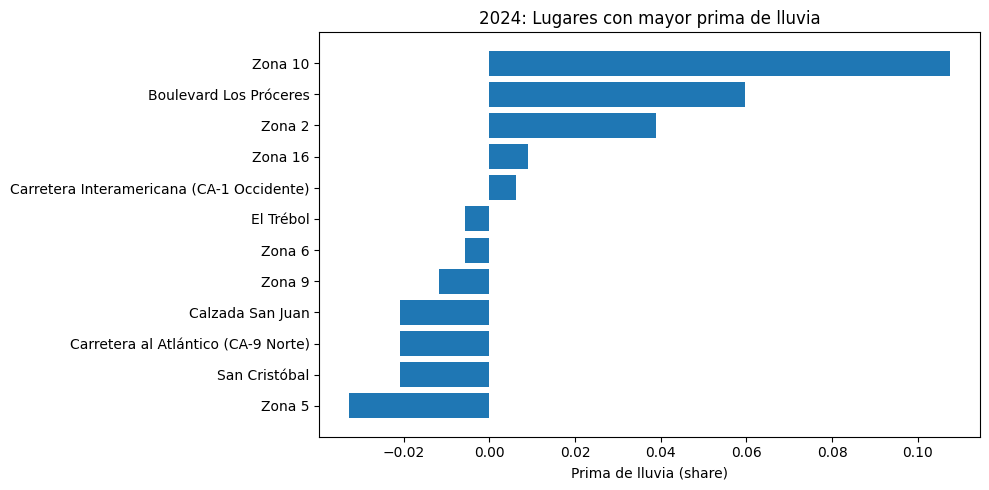

In [11]:

import numpy as np



if 'is_congestion' not in tweets_basic.columns:
    kw_pattern = re.compile(
        r"\b("
        r"trafic[oó]"
        r"|atasc[oa]s?"
        r"|congesti[óo]n|congestionad[oa]s?"
        r"|lento[s]?"
        r"|accidente[s]?"
        r"|choque[s]?"
        r"|colapsad[oa]s?"
        r"|embotellamiento[s]?|embotellad[oa]s?"
        r"|obstrucci[óo]n"
        r"|paralizad[oa]s?"
        r"|carga\s+vehicular"
        r")",
        flags=re.IGNORECASE
    )
    tmp = tweets_basic[tweets_basic["lang"].fillna("").str.startswith("es")].copy()
    tweets_basic["is_congestion"] = tmp["text_clean"].fillna("").apply(lambda s: bool(kw_pattern.search(s)))


if 'locations' not in tweets_basic.columns:
    TOPONYMS = {
        r"\banillo\s+periferic[oa]\b|\bperiferic[oa]\b|\bperi\b": "Anillo Periférico",
        r"\bcalzada\s+roosevelt\b|\broosevelt\b": "Calzada Roosevelt",
        r"\bcalzada\s+aguilar\s+batres\b|\baguilar\s+batres\b|\baguilarbatres\b": "Calzada Aguilar Batres",
        r"\bcalzada\s+san\s+juan\b|\bsan\s+juan\b": "Calzada San Juan",
        r"\bavenida\s+petapa\b|\bpetapa\b": "Avenida Petapa",
        r"\bb(ou)?levar(d)?\s+liberaci[oó]n\b|\bliberaci[oó]n\b": "Bulevar Liberación",
        r"\bavenida\s+reforma\b|\breforma\b": "Avenida Reforma",
        r"\batanasio\s+tzul\b|\batanasio\b": "Calzada Atanasio Tzul",
        r"\bhincapi[eé]\b": "Hincapié",
        r"\blos\s+pr[oó]ceres\b|\bpr[oó]ceres\b": "Boulevard Los Próceres",
        r"\blas\s+am[eé]ricas\b": "Avenida Las Américas",
        r"\bel\s+tr[eé]bol\b|\btr[eé]bol\b": "El Trébol",
        r"\bobelisco\b": "Obelisco",
        r"\bpuente\s+belice\b": "Puente Belice",
        r"\bpuente\s+(del\s+)?incienso\b|\bincienso\b": "Puente El Incienso",
        r"\bcarretera\s+a(l)?\s+el\s+salvador\b|\bcarretera\s+el\s+salvador\b": "Carretera a El Salvador (CA-1 Oriente)",
        r"\bcarretera\s+a(l)?\s+pac[íi]fico\b|\bpac[íi]fico\b": "Carretera al Pacífico (CA-9 Sur)",
        r"\bcarretera\s+a(l)?\s+atl[aá]ntico\b|\batl[aá]ntico\b": "Carretera al Atlántico (CA-9 Norte)",
        r"\binteramericana\b|\bcarretera\s+interamericana\b": "Carretera Interamericana (CA-1 Occidente)",
        r"\bsan\s+crist[oó]bal\b|\bciudad\s+san\s+crist[oó]bal\b": "San Cristóbal",
        r"\bel\s+naranjo\b": "El Naranjo",
        r"\bmixco\b": "Mixco",
        r"\bvilla\s+nueva\b|\bvillenueva\b": "Villa Nueva",
        r"\bboca\s+del\s+monte\b": "Boca del Monte",
    }
    RE_ZONA = re.compile(r"\bz(?:ona)?\s*(\d{1,2})\b")
    RE_CA   = re.compile(r"\bca[-\s]?(\d{1,2})\b")
    RE_KM   = re.compile(r"\bkm\s*(\d{1,3})\b", re.IGNORECASE)

    def extract_locations(text: str):
        locs = []
        if not isinstance(text, str) or not text:
            return locs
        s = text.lower()
        for pat, canon in TOPONYMS.items():
            if re.search(pat, s): locs.append(canon)
        for m in RE_ZONA.finditer(s):
            n = int(m.group(1))
            if 0 < n <= 25: locs.append(f"Zona {n}")
        for m in RE_CA.finditer(s): locs.append(f"CA-{m.group(1)}")
        for m in RE_KM.finditer(s): locs.append(f"KM-{m.group(1)}")
        seen, uniq = set(), []
        for x in locs:
            if x not in seen:
                uniq.append(x); seen.add(x)
        return uniq

    tweets_basic["locations"] = tweets_basic["text_clean"].fillna("").apply(extract_locations)


base = tweets_basic[
    tweets_basic["lang"].fillna("").str.startswith("es")
    & (tweets_basic["is_congestion"] == True)
].copy()

long_locs = base.explode("locations", ignore_index=True)
long_locs = long_locs[long_locs["locations"].notna() & (long_locs["locations"] != "")].copy()


year_season_tot = (long_locs.groupby(["year","rainy_season"])
                   .size().rename("tot_year_season").reset_index())

loc_year_season = (long_locs.groupby(["locations","year","rainy_season"])
                   .size().rename("count").reset_index())
loc_year_season = loc_year_season.merge(year_season_tot, on=["year","rainy_season"], how="left")
loc_year_season["share"] = (loc_year_season["count"] / loc_year_season["tot_year_season"]).round(4)

# Prima de lluvia 2024
MIN_TOTAL_2024 = 4
tot_loc_2024 = (loc_year_season[loc_year_season["year"]==2024]
                .groupby("locations")["count"]
                .sum().rename("total_2024"))
ls2024 = loc_year_season[loc_year_season["year"]==2024].merge(tot_loc_2024, on="locations", how="left")
ls2024 = ls2024[ls2024["total_2024"].fillna(0) >= MIN_TOTAL_2024]

pivot2024 = ls2024.pivot(index="locations", columns="rainy_season", values="share").fillna(0)
pivot2024.columns = ["Seca", "Lluvia"] if list(pivot2024.columns) == [False, True] else pivot2024.columns
pivot2024["rain_premium"] = pivot2024.get("Lluvia", 0) - pivot2024.get("Seca", 0)
pivot2024 = pivot2024.join(tot_loc_2024, how="left")

top_rain_premium_2024 = pivot2024.sort_values("rain_premium", ascending=False).head(12)
bottom_rain_premium_2024 = pivot2024.sort_values("rain_premium", ascending=True).head(12)

print("== 2024: Top prima de lluvia (share lluvia - share seca) ==")
display(top_rain_premium_2024.round(4))

print("\n== 2024: Prima negativa (lugares mas 'secos') ==")
display(bottom_rain_premium_2024.round(4))


def premium_for_year(y):
    tmp = loc_year_season[loc_year_season["year"]==y]
    pv = tmp.pivot(index="locations", columns="rainy_season", values="share").fillna(0)
    pv.columns = ["Seca", "Lluvia"] if list(pv.columns) == [False, True] else pv.columns
    pv["rain_premium"] = pv.get("Lluvia", 0) - pv.get("Seca", 0)
    return pv[["rain_premium"]]

prem23 = premium_for_year(2023).rename(columns={"rain_premium":"premium_2023"})
prem24 = premium_for_year(2024).rename(columns={"rain_premium":"premium_2024"})
persist = prem23.join(prem24, how="inner")
persist["same_sign"] = np.sign(persist["premium_2023"]) == np.sign(persist["premium_2024"])
persist_pos = persist[persist["same_sign"] & (persist["premium_2024"] > 0)].sort_values("premium_2024", ascending=False).head(12)

print("\n== Persistencia: prima de lluvia positiva en 2023 y 2024 ==")
display(persist_pos.round(4))


plt.figure(figsize=(10,5))
plt.barh(top_rain_premium_2024.index[::-1], top_rain_premium_2024["rain_premium"][::-1])
plt.xlabel("Prima de lluvia (share)")
plt.title("2024: Lugares con mayor prima de lluvia")
plt.tight_layout()
plt.show()


Extraccion de interacciones y estructura de red

- Extraemos **menciones**, **respuestas**, **retweets** y **citas** desde los metadatos si existen; si faltan, usamos fallback por texto.
- Normalizamos usuarios (`@user` → `user` en minusculas)
- Eliminamos **duplicados** por (`tweet_id`, `type`, `source`, `target`).
- Construimos:
  - `edges`: aristas dirigidas con `type  {mention, reply, retweet, quote}`.
  - `nodes`: usuarios con grados de entrada/salida por tipo y totales.
- Guardamos en `data/edges.parquet` y `data/nodes.parquet`.

In [13]:




if 'df' not in globals():

    from pathlib import Path
    import json
    def sniff_encoding(path: Path) -> str:
        with open(path, "rb") as fb:
            head = fb.read(4)
        if head.startswith(b"\xff\xfe"): return "utf-16-le"
        if head.startswith(b"\xfe\xff"): return "utf-16-be"
        if head.startswith(b"\xef\xbb\xbf"): return "utf-8-sig"
        if b"\x00" in head: return "utf-16-le"
        return "utf-8"
    def iter_lines_text(path: Path):
        enc = sniff_encoding(path)
        with open(path, "r", encoding=enc, errors="replace") as f:
            for line in f:
                yield line
    def load_jsonl_smart(filepath: Path) -> pd.DataFrame:
        records = []
        for raw in iter_lines_text(filepath):
            line = raw.strip()
            if not line: continue
            if not line.startswith("{"):
                brace = line.find("{")
                if brace != -1: line = line[brace:]
                else: continue
            try:
                obj = json.loads(line)
                records.append(obj); continue
            except json.JSONDecodeError:
                pass
            depth = 0; end_index = -1
            for i,ch in enumerate(line):
                if ch == "{":
                    depth += 1
                elif ch == "}":
                    depth -= 1
                    if depth == 0:
                        end_index = i; break
            if end_index != -1:
                try:
                    obj = json.loads(line[: end_index + 1])
                    records.append(obj)
                except Exception:
                    pass
        if not records: return pd.DataFrame()
        df0 = pd.json_normalize(records, sep="_")
        if "date" in df0.columns:
            df0["date"] = pd.to_datetime(df0["date"], errors="coerce", utc=True)
        return df0

    df = load_jsonl_smart(Path("data/traficogt.txt"))

assert "user_username" in df.columns, "El dataset no tiene 'user_username'. Revisa la carga inicial."


def norm_user(u):
    if u is None or (isinstance(u, float) and math.isnan(u)):
        return None
    u = str(u).strip()
    if not u: return None
    if u.startswith("@"): u = u[1:]
    u = u.lower()
    u = re.sub(r"[^a-z0-9_]", "", u)
    return u or None


if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True)
    df["date_local"] = df["date"].dt.tz_convert("America/Guatemala")
else:
    df["date_local"] = pd.NaT

df["author"] = df["user_username"].apply(norm_user)


MENTION_RE = re.compile(r'@([A-Za-z0-9_]{2,30})')

def extract_mentions_row(row):

    mentions = set()
    if "mentionedUsers" in row and isinstance(row["mentionedUsers"], list):
        for m in row["mentionedUsers"]:
            if isinstance(m, dict):
                u = norm_user(m.get("username"))
            else:
                u = norm_user(m)
            if u: mentions.add(u)

    text = row.get("rawContent") or row.get("content") or ""
    for m in MENTION_RE.finditer(str(text)):
        u = norm_user(m.group(1))
        if u: mentions.add(u)
    # quitar self-mention
    au = row.get("author")
    if au in mentions:
        mentions.discard(au)
    return sorted(mentions)

def extract_reply_target_row(row):
    # posibles columnas: inReplyToUser_username / inReplyToUser_user_username / inReplyToUser (dict)
    for k in ["inReplyToUser_username", "inReplyToUser_user_username", "inReplyToUser", "inReplyToUser_user"]:
        if k in row and row[k] is not None and not (isinstance(row[k], float) and math.isnan(row[k])):
            val = row[k]
            if isinstance(val, dict):
                return norm_user(val.get("username"))
            return norm_user(val)
    # fallback: si el texto inicia con @user
    text = row.get("rawContent") or row.get("content") or ""
    m = re.match(r'^\s*@([A-Za-z0-9_]{2,30})', str(text))
    if m:
        return norm_user(m.group(1))
    return None

def extract_retweet_target_row(row):
    # json_normalize suele crear: retweetedTweet_user_username
    for k in ["retweetedTweet_user_username", "retweetedTweet_user_screen_name", "retweetedTweet_user"]:
        if k in row and row[k] is not None and not (isinstance(row[k], float) and math.isnan(row[k])):
            val = row[k]
            if isinstance(val, dict):
                return norm_user(val.get("username"))
            return norm_user(val)
    return None

def extract_quote_target_row(row):
    for k in ["quotedTweet_user_username", "quotedTweet_user", "quoted_user_username"]:
        if k in row and row[k] is not None and not (isinstance(row[k], float) and math.isnan(row[k])):
            val = row[k]
            if isinstance(val, dict):
                return norm_user(val.get("username"))
            return norm_user(val)
    return None

# edges
edges = []
for _, r in df.iterrows():
    src = r.get("author")
    if not src: 
        continue
    twid = r.get("id")
    dtloc = r.get("date_local")

    # mentions (0..n)
    try:
        for trg in extract_mentions_row(r):
            if trg and trg != src:
                edges.append((twid, dtloc, src, trg, "mention"))
    except Exception:
        pass

    # reply
    try:
        trg = extract_reply_target_row(r)
        if trg and trg != src:
            edges.append((twid, dtloc, src, trg, "reply"))
    except Exception:
        pass

    # retweet
    try:
        trg = extract_retweet_target_row(r)
        if trg and trg != src:
            edges.append((twid, dtloc, src, trg, "retweet"))
    except Exception:
        pass

    # quote 
    try:
        trg = extract_quote_target_row(r)
        if trg and trg != src:
            edges.append((twid, dtloc, src, trg, "quote"))
    except Exception:
        pass

edges_df = pd.DataFrame(edges, columns=["tweet_id","date_local","source","target","type"])

# Limpieza: quitar nulos, self-loops y duplicados
edges_df = edges_df.dropna(subset=["source","target"])
edges_df = edges_df[edges_df["source"] != edges_df["target"]]
edges_df = edges_df.drop_duplicates(subset=["tweet_id","type","source","target"], keep="first")

# agregados por par (para analisis de red)
agg = (edges_df
       .groupby(["source","target","type"])
       .size()
       .rename("weight")
       .reset_index())

# 7) Nodos con grados
nodes = pd.DataFrame({
    "user": pd.unique(pd.concat([agg["source"], agg["target"]], ignore_index=True))
})
# in/out por tipo
for t in ["mention","reply","retweet","quote"]:
    in_deg  = agg.loc[agg["type"]==t].groupby("target")["weight"].sum()
    out_deg = agg.loc[agg["type"]==t].groupby("source")["weight"].sum()
    nodes[f"in_{t}"]  = nodes["user"].map(in_deg).fillna(0).astype(int)
    nodes[f"out_{t}"] = nodes["user"].map(out_deg).fillna(0).astype(int)

nodes["in_total"]  = nodes[[c for c in nodes.columns if c.startswith("in_")]].sum(axis=1)
nodes["out_total"] = nodes[[c for c in nodes.columns if c.startswith("out_")]].sum(axis=1)
nodes["degree"]    = nodes["in_total"] + nodes["out_total"]


outdir = Path("data"); outdir.mkdir(parents=True, exist_ok=True)
edges_path = outdir / "edges.parquet"
nodes_path = outdir / "nodes.parquet"
try:
    edges_df.to_parquet(edges_path, index=False)
    nodes.to_parquet(nodes_path, index=False)
    saved = (edges_path, nodes_path)
except Exception as e:
    
    edges_path = outdir / "edges.csv"
    nodes_path = outdir / "nodes.csv"
    edges_df.to_csv(edges_path, index=False, encoding="utf-8")
    nodes.to_csv(nodes_path, index=False, encoding="utf-8")
    saved = (edges_path, nodes_path)
    print("Guardado como CSV (Parquet no disponible). Detalle:", e)


print("Aristas unicas (source a target x tipo):", len(agg))
print(agg["type"].value_counts())
print("\nTop 10 nodos por grado total:")
display(nodes.sort_values("degree", ascending=False).head(10))

print("\nArchivos guardados en:", saved)


Aristas unicas (source a target x tipo): 10904
type
mention    7414
reply      3286
quote       204
Name: count, dtype: int64

Top 10 nodos por grado total:


,user,in_mention,out_mention,in_reply,out_reply,in_retweet,out_retweet,in_quote,out_quote,in_total,out_total,degree
1848,traficogt,4232,115,1390,34,0,0,0,550,5622,699,6321
1974,barevalodeleon,426,0,49,0,0,0,0,0,475,0,475
217,batallonjalapa,2,324,2,132,0,0,0,0,4,456,460
1382,mildred_gaitan,18,278,15,103,0,0,1,3,34,384,418
1581,prensacomunitar,162,16,119,0,0,0,41,0,322,16,338
1128,lahoragt,128,2,108,0,0,0,73,0,309,2,311
128,amilcarmontejo,165,2,59,1,0,0,0,0,224,3,227
1395,mmendoza_gt,131,7,60,0,0,0,10,0,201,7,208
153,angeln8,0,152,0,42,0,0,0,3,0,197,197
422,cubreserva,17,151,17,4,0,0,0,0,34,155,189



Archivos guardados en: (PosixPath('data/edges.parquet'), PosixPath('data/nodes.parquet'))


# Topologia de la red dirigida

Se construyen grafos dirigidos por tipo de interaccion y se calculan metricas clave:
- **Densidad** (m/(n·(n−1)) en dirigido),
- **Diametro** (sobre el mayor componente *débilmente* conectado, proyectado a no-dirigido),
- **Coeficiente de agrupamiento** (clustering medio, en proyeccion no-dirigida).

tambien, se genera un subgrafo de alto grado.



== Metricas de red (dirigida diametro/clustering sobre LCC no-dirigido) ==


,name,nodes,edges,density,lcc_nodes,diameter_lcc,avg_clustering_lcc,transitivity_lcc
0,all,2787,7600,0.000979,2787,4,0.335292,0.006337
1,mention,2763,7414,0.000972,2763,7,0.230234,0.004726
2,reply,2241,3286,0.000655,2076,12,0.030251,0.001062
3,quote,222,204,0.004158,182,7,0.021979,0.000448


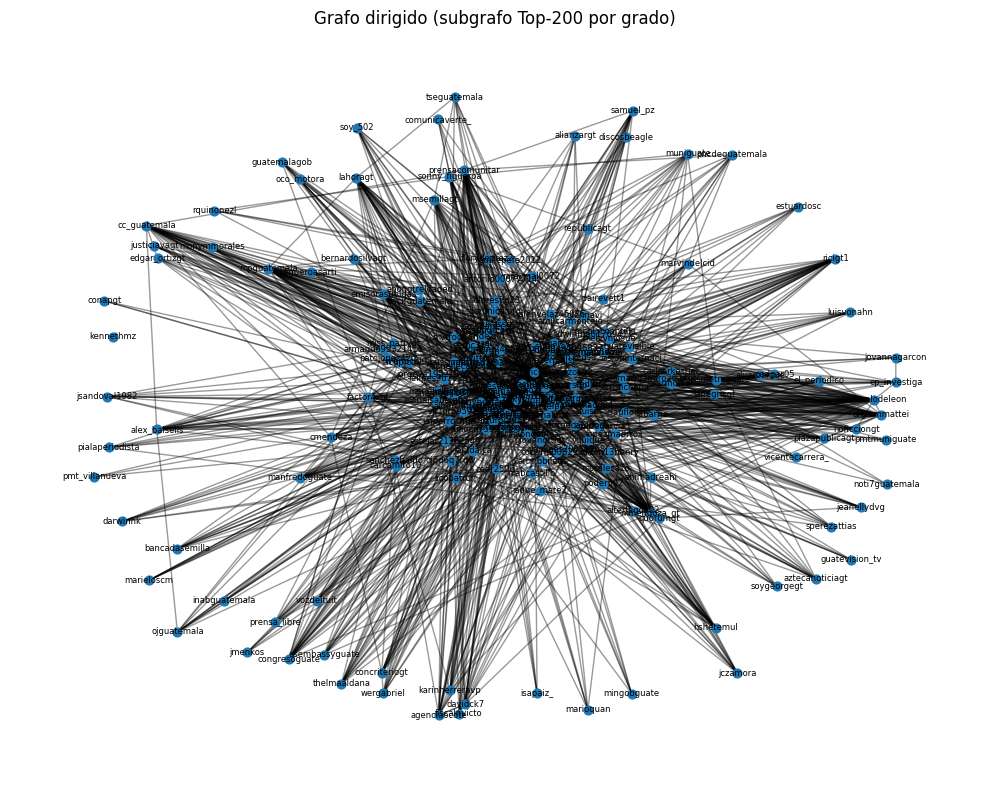

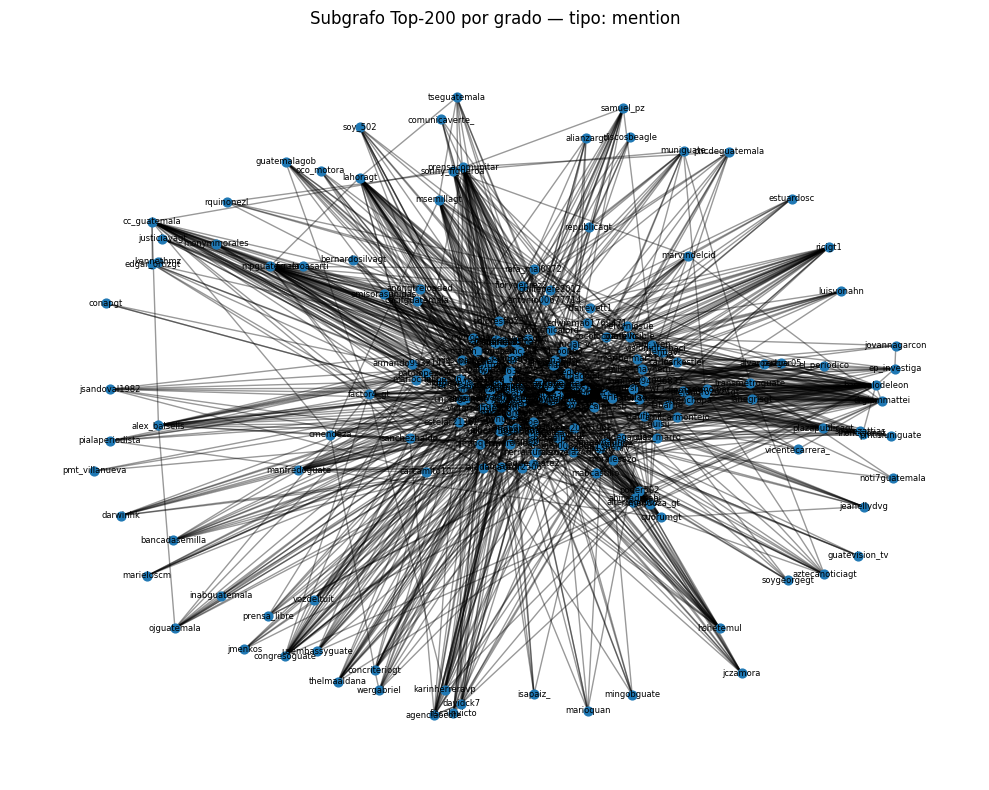

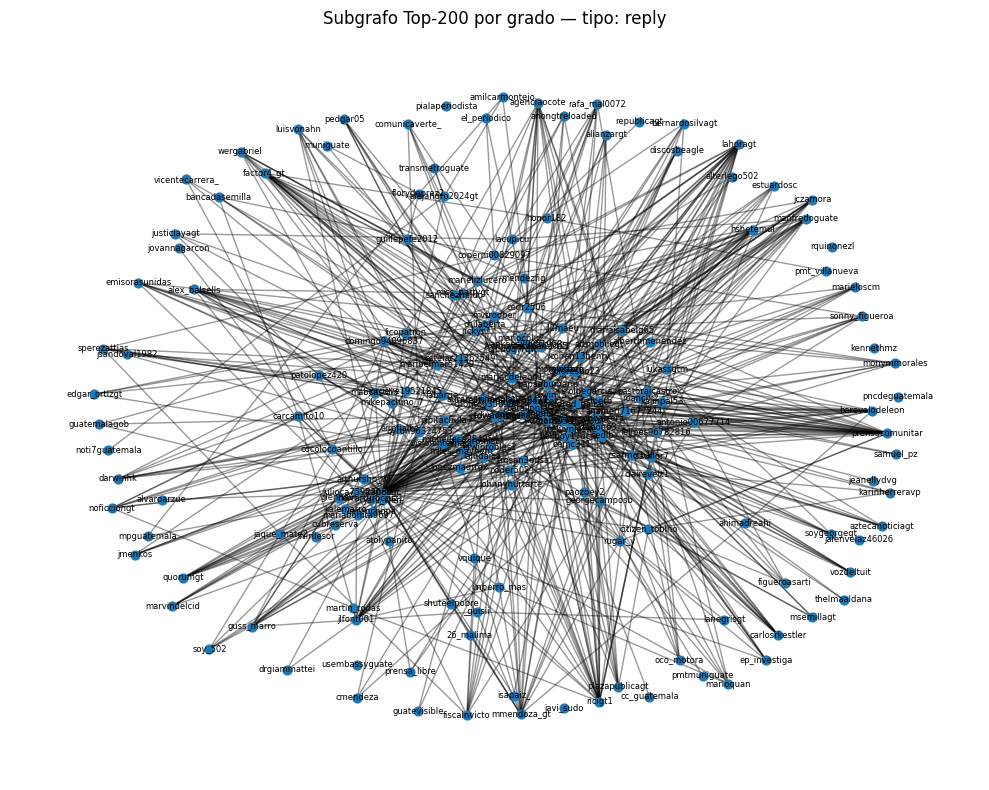

In [16]:


import networkx as nx


# Cargar aristas y nodos
edges_path = Path("data/edges.parquet")
nodes_path = Path("data/nodes.parquet")
if edges_path.exists():
    edges_df = pd.read_parquet(edges_path)
else:
    edges_df = pd.read_csv("data/edges.csv")
if nodes_path.exists():
    nodes_df = pd.read_parquet(nodes_path)
else:
    nodes_df = pd.read_csv("data/nodes.csv")

# Grafo dirigido total (todas las interacciones)
G = nx.DiGraph()
G.add_nodes_from(nodes_df["user"].tolist())
# Multiples aristas colapsadas por (source,target,type)
# Usamos peso = cantidad de interacciones de ese tipo entre el par
w = (edges_df
     .groupby(["source","target","type"])
     .size()
     .rename("weight")
     .reset_index())

# Agregar con etiqueta de tipo como atributo
for row in w.itertuples(index=False):
    # Podria existir arista source a target ya con otro tipo; sumamos pesos por tipo en atributo dict
    if G.has_edge(row.source, row.target):
        # acumulamos por tipo dentro de un dict en 'types'
        data = G[row.source][row.target]
        data["weight"] = data.get("weight", 0) + row.weight
        types = data.get("types", {})
        types[row.type] = types.get(row.type, 0) + row.weight
        data["types"] = types
    else:
        G.add_edge(row.source, row.target, weight=row.weight, types={row.type: row.weight})

# 3) Subgrafos por tipo (para metricas comparables)
Gs = {}
for t in ["mention", "reply", "quote"]:
    ew = w[w["type"] == t][["source","target","weight"]]
    g = nx.DiGraph()
    g.add_weighted_edges_from(ew[['source','target','weight']].itertuples(index=False, name=None))
    Gs[t] = g

def directed_metrics(graph: nx.DiGraph, name: str):
    n = graph.number_of_nodes()
    m = graph.number_of_edges()
    dens = nx.density(graph) if n > 1 else np.nan

    # Para diametro y clustering, trabajamos en el mayor componente *no-dirigido*
    if n == 0 or m == 0:
        diam = np.nan
        avg_clust = np.nan
        trans = np.nan
        n_lcc = 0
    else:
        UG = graph.to_undirected()
        if UG.number_of_edges() == 0 or UG.number_of_nodes() == 0:
            diam = np.nan; avg_clust = np.nan; trans = np.nan; n_lcc = 0
        else:
            # mayor componente conectado
            largest_cc_nodes = max(nx.connected_components(UG), key=len)
            H = UG.subgraph(largest_cc_nodes).copy()
            n_lcc = H.number_of_nodes()
            try:
                diam = nx.diameter(H)  # puede tardar si H es muy grande
            except Exception:
                # fallback: usar excentricidad aproximada (si fallara por performance)
                ecc = nx.eccentricity(H)
                diam = max(ecc.values()) if ecc else np.nan
            avg_clust = nx.average_clustering(H)
            trans = nx.transitivity(H)

    return {
        "name": name,
        "nodes": n,
        "edges": m,
        "density": dens,
        "lcc_nodes": n_lcc,
        "diameter_lcc": diam,
        "avg_clustering_lcc": avg_clust,
        "transitivity_lcc": trans,
    }

# 4) Metricas para el total y por tipo
rows = [directed_metrics(G, "all")] + [directed_metrics(Gs[t], t) for t in Gs]
metrics_df = pd.DataFrame(rows)
print("== Metricas de red (dirigida diametro/clustering sobre LCC no-dirigido) ==")
display(metrics_df)

# Visualizacion de subgrafo de alto grado (top-N)
# Se seleccionaron los N usuarios con mayor "degree" (in+out) y las aristas entre ellos
N = 200
top_nodes = (nodes_df
             .sort_values("degree", ascending=False)
             .head(N)["user"]
             .tolist())
Hdir = G.subgraph(top_nodes).copy()


pos = nx.spring_layout(Hdir, k=0.15, iterations=50, seed=7)
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(Hdir, pos, node_size=40)
nx.draw_networkx_edges(Hdir, pos, arrows=False, alpha=0.4)
nx.draw_networkx_labels(Hdir, pos, font_size=6, font_weight="normal")
plt.title(f"Grafo dirigido (subgrafo Top-{N} por grado)")
plt.axis("off")
plt.tight_layout()
plt.show()


for t in ["mention","reply"]:
    Hg = Gs[t].subgraph(top_nodes).copy()
    if Hg.number_of_nodes() == 0:
        continue
    pos = nx.spring_layout(Hg, k=0.15, iterations=50, seed=7)
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(Hg, pos, node_size=40)
    nx.draw_networkx_edges(Hg, pos, arrows=False, alpha=0.4)
    nx.draw_networkx_labels(Hg, pos, font_size=6)
    plt.title(f"Subgrafo Top-{N} por grado — tipo: {t}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


## Comunidades (deteccion, visualizacion y caracterizacion)

**Algoritmo:** Louvain (esta en NetworkX) y como respaldo, Greedy Modularity.  
**Entradas:** `G` (grafo dirigido) y `nodes_df`, `edges_df`, `tweets_basic`.  
**Salidas:**
- `node_communities.parquet` que son la asignacion usuario a comunidad.
- `community_summary.parquet` que es el tamaño, densidad interna, top centralidades.
- Figuras: top-3 comunidades (subgrafos).


Algoritmo de comunidades usado: louvain
Numero de comunidades detectadas: 51


,community,size,edges_internal,density_internal,top_degree,top_betweenness
0,0,894,1284,0.0032,"[traficogt, barevalodeleon, cacifguatemala, ch...","[traficogt, barevalodeleon, miciviguate, madim..."
1,1,248,352,0.0115,"[prensacomunitar, batallonjalapa, cc_guatemala...","[prensacomunitar, cc_guatemala, batallonjalapa..."
2,2,237,461,0.0165,"[amilcarmontejo, muniguate, pmtmuniguate, azte...","[amilcarmontejo, muniguate, kaialer, aztecanot..."
3,3,197,334,0.0173,"[mildred_gaitan, agenciaocote, davidck7, facto...","[mildred_gaitan, davidck7, factor4_gt, victorp..."
4,4,170,283,0.0197,"[jlfont001, ricigt1, concriteriogt, msemillagt...","[ricigt1, de_don61347, jaque_mate2, concriteri..."
5,5,159,344,0.0274,"[cubreserva, quorumgt, emisorasunidas, nilrile...","[pialaperiodista, quorumgt, emisorasunidas, sa..."
6,6,154,208,0.0177,"[lahoragt, mpguatemala, miss_pattygt, citizen_...","[lahoragt, mpguatemala, felipes96782816, miss_..."
7,7,146,206,0.0195,"[mmendoza_gt, drgiammattei, lanegrisgt, vicent...","[drgiammattei, mmendoza_gt, lanegrisgt, matias..."
8,8,78,107,0.0356,"[giovanottigt, jmenkos, wamado04, extasisvgame...","[wamado04, giovanottigt, extasisvgames, jodito..."
9,9,69,97,0.0413,"[sonny_figueroa, marieloscm, johnnyhurtarte, m...","[sonny_figueroa, johnnyhurtarte, marieloscm, g..."


,community,top_terms,tweets_es
0,0,"[barevalodeleon, está, corruptos, están, ahora...",2211
1,1,"[prensacomunitar, presidente, está, barevalode...",500
2,2,"[amilcarmontejo, calle, tráfico, villa, libre,...",345
6,6,"[lahoragt, mpguatemala, detalles, ahoralh, cor...",308
3,3,"[agenciaocote, mpguatemala, drgiammattei, davi...",300
4,4,"[ricigt1, jlfont001, concriteriogt, msemillagt...",298
5,5,"[emisorasunidas, quorumgt, jeanellydvg, samuel...",215
7,7,"[mmendoza, drgiammattei, lanegrisgt, president...",166
10,10,"[domingo94096837, pueblo, investiga, barevalod...",118
8,8,"[jmenkos, barevalodeleon, joditocruz, pueblo, ...",114


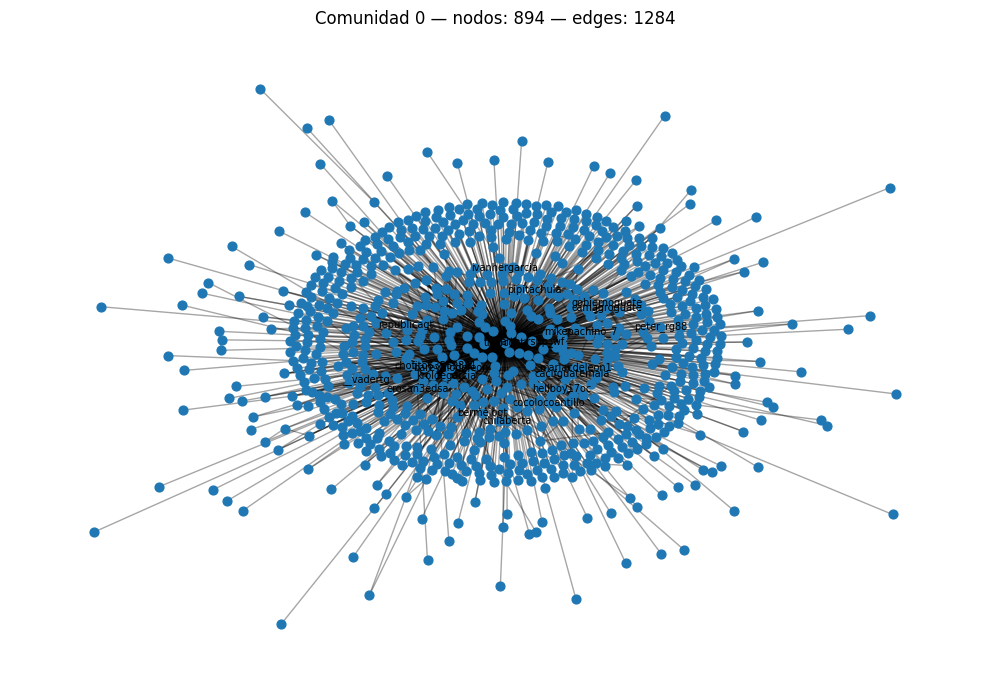

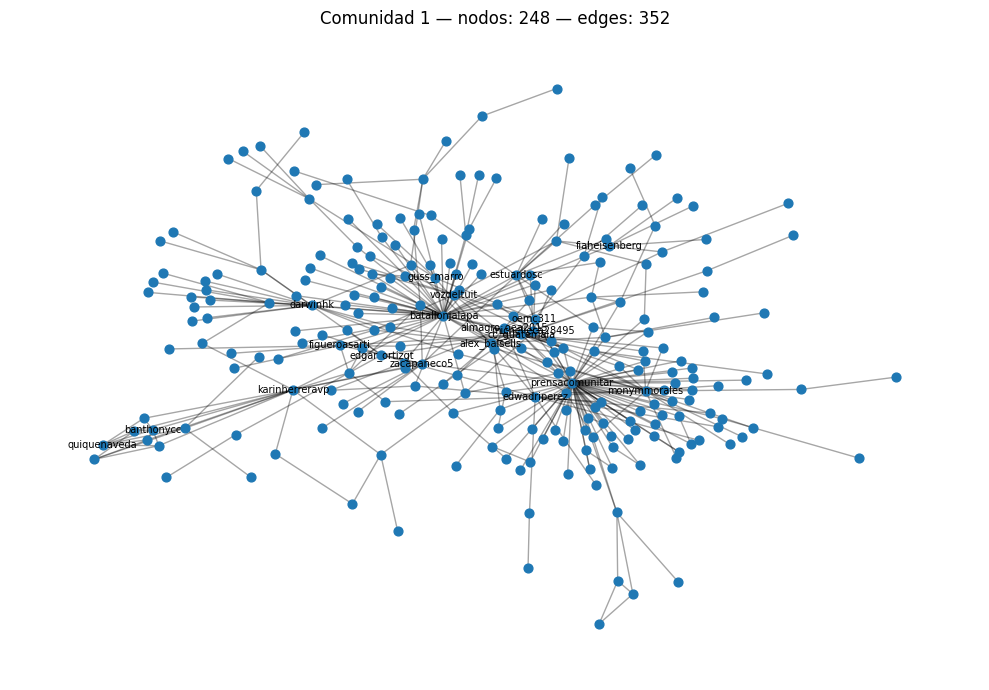

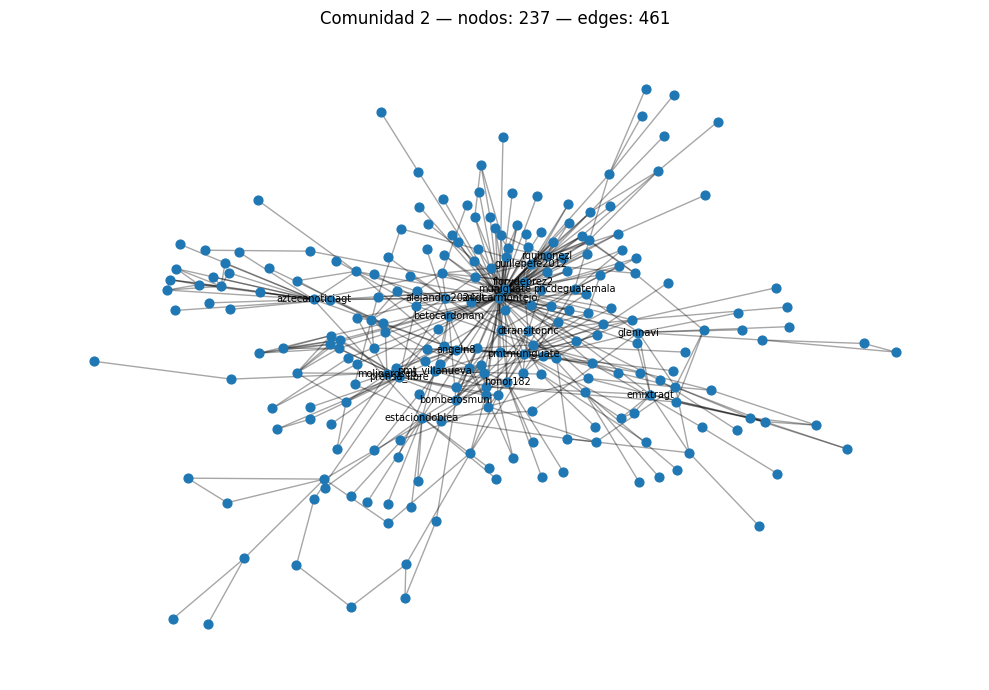

Guardado: data/node_communities.parquet data/community_summary.parquet data/community_topics.parquet


In [17]:


if 'G' not in globals() or not isinstance(G, nx.DiGraph):
    edges_path = Path("data/edges.parquet")
    nodes_path = Path("data/nodes.parquet")
    edges_df = pd.read_parquet(edges_path) if edges_path.exists() else pd.read_csv("data/edges.csv")
    nodes_df = pd.read_parquet(nodes_path) if nodes_path.exists() else pd.read_csv("data/nodes.csv")
    G = nx.DiGraph()
    G.add_nodes_from(nodes_df["user"].tolist())
    w = (edges_df.groupby(["source","target","type"]).size().rename("weight").reset_index())
    for row in w.itertuples(index=False):
        if G.has_edge(row.source, row.target):
            data = G[row.source][row.target]
            data["weight"] = data.get("weight", 0) + row.weight
            types = data.get("types", {})
            types[row.type] = types.get(row.type, 0) + row.weight
            data["types"] = types
        else:
            G.add_edge(row.source, row.target, weight=row.weight, types={row.type: row.weight})

if 'tweets_basic' not in globals():
    tb_path = Path("data/tweets_clean.parquet")
    tweets_basic = pd.read_parquet(tb_path) if tb_path.exists() else pd.read_csv("data/tweets_clean.csv")

# Grafo no dirigido para deteccion de comunidades sumando pesos
UG = nx.Graph()
for u, v, d in G.edges(data=True):
    w = d.get("weight", 1)
    if UG.has_edge(u, v):
        UG[u][v]["weight"] += w
    else:
        UG.add_edge(u, v, weight=w)

# Deteccion de comunidades Louvain si existe, sino Greedy
method = "louvain"
communities = None
try:
    from networkx.algorithms.community import louvain_communities
    communities = louvain_communities(UG, weight="weight", seed=42)
except Exception:
    method = "greedy_modularity"
    from networkx.algorithms.community import greedy_modularity_communities
    communities = list(greedy_modularity_communities(UG, weight="weight"))

print(f"Algoritmo de comunidades usado: {method}")
print(f"Numero de comunidades detectadas: {len(communities)}")

# --Asignacion nodo a comunidad
comm_map = {}
for cid, comm in enumerate(sorted(communities, key=len, reverse=True)):
    for node in comm:
        comm_map[node] = cid

nodes_df = nodes_df.copy()
nodes_df["community"] = nodes_df["user"].map(comm_map).fillna(-1).astype(int)

# -Resumen por comunidad: tamaño, densidad interna, centralidades top ---
summary_rows = []
for cid, comm in enumerate(sorted(communities, key=len, reverse=True)):
    subU = UG.subgraph(comm)
    size = subU.number_of_nodes()
    edges_in = subU.number_of_edges()
    dens_in = nx.density(subU) if size > 1 else np.nan

    # Centralidades (en subgrafo no-dirigido)
    deg = dict(subU.degree())
    btwn = nx.betweenness_centrality(subU, normalized=True, weight="weight")
    # Top 5 por grado y aldeaños
    top_deg = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:5]
    top_bt  = sorted(btwn.items(), key=lambda x: x[1], reverse=True)[:5]

    summary_rows.append({
        "community": cid,
        "size": size,
        "edges_internal": edges_in,
        "density_internal": round(dens_in, 4),
        "top_degree": [u for u,_ in top_deg],
        "top_betweenness": [u for u,_ in top_bt],
    })

community_summary = pd.DataFrame(summary_rows)
display(community_summary.head(10))

# -- Caracterizacion tematica de comunidades ---
# Normalizamos autor para mapear tweets → comunidad
def norm_user(u):
    if u is None or (isinstance(u, float) and math.isnan(u)):
        return None
    u = str(u).strip().lower()
    if u.startswith("@"): u = u[1:]
    u = re.sub(r"[^a-z0-9_]", "", u)
    return u or None

tb = tweets_basic.copy()
tb["author_norm"] = tb.get("user_username", "").map(norm_user)
tb["community"] = tb["author_norm"].map(comm_map)
tb_es = tb[(tb["lang"].fillna("").str.startswith("es")) & (tb["community"].notna())]

# tokens simples desde text_clean
def tokens(s):
    if not isinstance(s, str): return []
    return [t for t in s.split() if len(t) >= 3][:40]  # limite defensivo por tweet

from collections import Counter
topic_rows = []
for cid, grp in tb_es.groupby("community"):
    cnt = Counter()
    for s in grp.get("text_clean", []):
        cnt.update(tokens(s))
    # quitamos terminos  generales
    stop_like = {"trafico","traficogt","guatemala","ciudad","zona","pmt","muniguate","pnc","gt"}
    top_terms = [w for w,_ in cnt.most_common(30) if w not in stop_like][:12]
    topic_rows.append({"community": int(cid), "top_terms": top_terms, "tweets_es": len(grp)})
topics_df = pd.DataFrame(topic_rows).sort_values("tweets_es", ascending=False)
display(topics_df.head(10))


top3 = community_summary.sort_values("size", ascending=False).head(3)["community"].tolist()
for cid in top3:
    nodes_c = nodes_df[nodes_df["community"] == cid]["user"].tolist()
    H = UG.subgraph(nodes_c).copy()
    if H.number_of_nodes() == 0: 
        continue
    pos = nx.spring_layout(H, k=0.2, iterations=60, seed=cid)
    plt.figure(figsize=(10,7))
    nx.draw_networkx_nodes(H, pos, node_size=40)
    nx.draw_networkx_edges(H, pos, alpha=0.35)
    # Etiquetamos solo los top por grado para legibilidad
    d_sorted = sorted(dict(H.degree()).items(), key=lambda x: x[1], reverse=True)[:20]
    labels = {u:u for u,_ in d_sorted}
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=7)
    plt.title(f"Comunidad {cid} — nodos: {H.number_of_nodes()} — edges: {H.number_of_edges()}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


outdir = Path("data"); outdir.mkdir(parents=True, exist_ok=True)
nodes_comm_path = outdir / "node_communities.parquet"
comm_summary_path = outdir / "community_summary.parquet"
topics_path = outdir / "community_topics.parquet"

try:
    nodes_df[["user","community"]].to_parquet(nodes_comm_path, index=False)
    community_summary.to_parquet(comm_summary_path, index=False)
    topics_df.to_parquet(topics_path, index=False)
except Exception:
    nodes_df[["user","community"]].to_csv(outdir / "node_communities.csv", index=False, encoding="utf-8")
    community_summary.to_csv(outdir / "community_summary.csv", index=False, encoding="utf-8")
    topics_df.to_csv(outdir / "community_topics.csv", index=False, encoding="utf-8")

print("Guardado:", nodes_comm_path, comm_summary_path, topics_path)


Detectamos 51 comunidades sobre la proyección no dirigida del grafo. Las tres mas grandes concentran la mayor interacción: **Comunidad 0** (894 nodos, 1,284 aristas) esta centrada en hubs como `traficogt` y `barevalodeleon`, sus terminos frecuentes sugieren conversacion politica y generalista alrededor de eventos del pais. **Comunidad 1** (248, 352) agrupa cuentas periodisticas y civicas donde por ejemplo `prensacomunitaria` con alta intermediacion y discurso de investigacion/denuncia. **Comunidad 2** (237, 461) concentra el **trafico operativo** y gestion vial como las cuentas de `amilcarmontejo`, `muniguate`, `pmtmuniguate`, coherente con reportes de incidentes y vias (Roosevelt, San Juan, CA-9). Los grafos muestran nucleos densos con periferias radiales, y los top por **grado** y **aldeaños** coinciden con los actores que articulan cada subred. Estas estructuras explican porque ciertos lugares/horas dominan en los reportes: la red amplifica lo vial en la comunidad 2 y lo politico e informativo en la 0–1.
